Calculated Chern number: -1.0


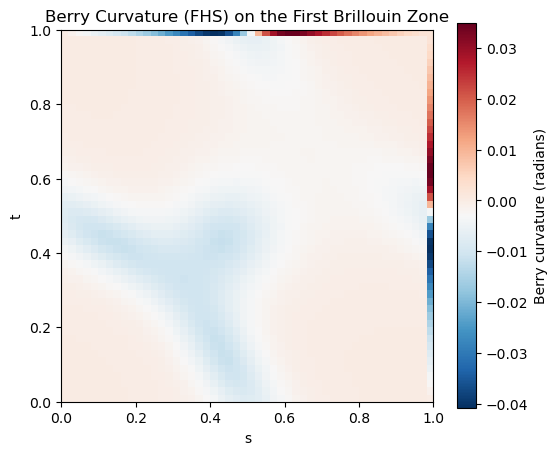

In [1]:
import numpy as np
import matplotlib.pyplot as plt

t1 = 2.0        # NN hopping amplitude
t2 = 0.5        # NNN hopping amplitude
phi = -np.pi/2   # Phase for NNN hopping
M = 1.0         # On-site staggered potential


a1 = np.array([0, -1])
a2 = np.array([np.sqrt(3)/2,  1/2])
a3 = np.array([-np.sqrt(3)/2, 1/2])
a_list = [a1, a2, a3]

b1 = np.array([np.sqrt(3), 0])
b2 = np.array([-np.sqrt(3)/2, 3/2])
b3 = np.array([-np.sqrt(3)/2, -3/2])
b_list = [b1, b2, b3]

def Haldane_H(kx, ky):
    d_x = 0.0
    d_y = 0.0
    for a in a_list:
        phase = np.dot([kx, ky], a)
        d_x += np.cos(phase)
        d_y += np.sin(phase)
    d_x *= t1
    d_y *= t1
    
    # d_z from on-site mass and NNN hopping:
    d_z = M
    for b in b_list:
        d_z -= 2 * t2 * np.sin(phi) * np.sin(np.dot([kx, ky], b))
    
    # Construct the Hamiltonian: H = d_x σ_x + d_y σ_y + d_z σ_z.
    Hk = np.array([[d_z, d_x - 1j*d_y],
                   [d_x + 1j*d_y, -d_z]], dtype=complex)
    return Hk

# --- Define the reciprocal lattice for the underlying Bravais lattice ---
# For the honeycomb lattice with Bravais vectors:
#   R1 = (sqrt3/2, 3/2)  and  R2 = (-sqrt3/2, 3/2)
# the reciprocal lattice vectors are:
b1_vec = np.array([2*np.pi/np.sqrt(3), 2*np.pi/3])
b2_vec = np.array([2*np.pi/np.sqrt(3), -2*np.pi/3])

# We'll generate the k-points as: k = s * b1_vec + t * b2_vec, with s,t in [0,1)
Ns = 50  # number of k-points along s
Nt = 50  # number of k-points along t

s_vals = np.linspace(0, 1, Ns, endpoint=False)
t_vals = np.linspace(0, 1, Nt, endpoint=False)

# Pre-allocate arrays to store eigenvector of the lower band.
eigvec_lower = np.zeros((Ns, Nt, 2), dtype=complex)
eigval_lower = np.zeros((Ns, Nt), dtype=float)

# Diagonalize H(k) for each k = s*b1 + t*b2.
for i, s in enumerate(s_vals):
    for j, t in enumerate(t_vals):
        k = s * b1_vec + t * b2_vec
        kx, ky = k
        Hk = Haldane_H(kx, ky)
        vals, vecs = np.linalg.eigh(Hk)
        # Lower band is the eigenstate with the lower eigenvalue.
        eigval_lower[i, j] = vals[0]
        eigvec_lower[i, j, :] = vecs[:, 0]

# Define a helper function to compute U(1) link variable between eigenstates.
def U_link(psi1, psi2):
    overlap = np.vdot(psi1, psi2)
    return overlap / np.abs(overlap)

# Compute the Berry curvature on each plaquette using the FHS method.
F = np.zeros((Ns, Nt))
for i in range(Ns):
    for j in range(Nt):
        ip = (i + 1) % Ns
        jp = (j + 1) % Nt
        U1 = U_link(eigvec_lower[i, j, :], eigvec_lower[ip, j, :])
        U2 = U_link(eigvec_lower[ip, j, :], eigvec_lower[ip, jp, :])
        U3 = U_link(eigvec_lower[ip, jp, :], eigvec_lower[i, jp, :])
        U4 = U_link(eigvec_lower[i, jp, :], eigvec_lower[i, j, :])
        # Berry curvature per plaquette (the sum of phases around the loop)
        F[i, j] = np.angle(U1 * U2 * U3 * U4)

# The total Chern number is the sum of Berry curvature divided by 2pi.
Chern = np.sum(F) / (2*np.pi)
print("Calculated Chern number:", np.round(Chern, 4))

# Optionally, visualize the Berry curvature over the first Brillouin zone.
plt.figure(figsize=(6,5))
plt.imshow(F.T, origin='lower', extent=[0,1,0,1], cmap='RdBu_r')
plt.colorbar(label='Berry curvature (radians)')
plt.xlabel('s')
plt.ylabel('t')
plt.title('Berry Curvature (FHS) on the First Brillouin Zone')
plt.show()


Computing Chern numbers on the (M, φ) grid ...


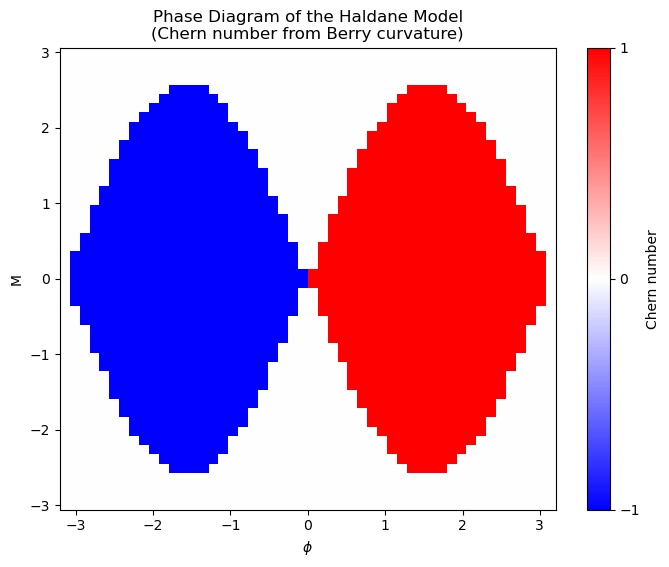

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fixed model parameters
t1 = 2.0        # nearest-neighbor hopping amplitude
t2 = 0.5        # next-nearest-neighbor hopping amplitude

# (We will vary M and φ.)
# Define nearest-neighbor (NN) vectors (as given earlier)
a1 = np.array([0, -1])
a2 = np.array([np.sqrt(3)/2, 1/2])
a3 = np.array([-np.sqrt(3)/2, 1/2])
a_list = [a1, a2, a3]

# Define next-nearest-neighbor (NNN) vectors (as given)
b1 = np.array([np.sqrt(3), 0])
b2 = np.array([-np.sqrt(3)/2, 3/2])
b3 = np.array([-np.sqrt(3)/2, -3/2])
b_list = [b1, b2, b3]

def Haldane_H(kx, ky, M, phi, t1=t1, t2=t2):
    # NN contributions to d_x and d_y:
    d_x = 0.0
    d_y = 0.0
    for a in a_list:
        phase = np.dot([kx, ky], a)
        d_x += np.cos(phase)
        d_y += np.sin(phase)
    d_x *= t1
    d_y *= t1

    # d_z from the on-site mass and the NNN hopping:
    d_z = M
    for b in b_list:
        d_z -= 2 * t2 * np.sin(phi) * np.sin(np.dot([kx, ky], b))

    # Hamiltonian H = d_x σ_x + d_y σ_y + d_z σ_z.
    Hk = np.array([[d_z, d_x - 1j*d_y],
                   [d_x + 1j*d_y, -d_z]], dtype=complex)
    return Hk

def U_link(psi1, psi2):
    """Compute the U(1) link variable (overlap) between two normalized eigenstates."""
    overlap = np.vdot(psi1, psi2)
    return overlap / np.abs(overlap)

def compute_chern(M, phi, Ns=30, Nt=30):
    """
    Compute the Chern number for the lower band of the Haldane model
    for a given on-site potential M and NNN phase φ.
    The first Brillouin zone is constructed using reciprocal lattice vectors.
    
    The real-space Bravais lattice vectors are taken as:
        R1 = (sqrt3/2, 3/2)  and  R2 = (-sqrt3/2, 3/2)
    The corresponding reciprocal lattice vectors are:
        b1_vec = (2π/√3, 2π/3)
        b2_vec = (2π/√3, -2π/3)
    and the k-points are generated as: k = s*b1_vec + t*b2_vec, with s,t in [0,1).
    """
    # Define reciprocal lattice vectors for the Bravais lattice:
    b1_vec = np.array([2*np.pi/np.sqrt(3),  2*np.pi/3])
    b2_vec = np.array([2*np.pi/np.sqrt(3), -2*np.pi/3])
    
    # Create the s and t parameters that span [0, 1)
    s_vals = np.linspace(0, 1, Ns, endpoint=False)
    t_vals = np.linspace(0, 1, Nt, endpoint=False)
    
    # Allocate array for the eigenvector of the lower band.
    eigvec_lower = np.zeros((Ns, Nt, 2), dtype=complex)
    
    # Diagonalize H(k) for each k = s*b1_vec + t*b2_vec.
    for i, s in enumerate(s_vals):
        for j, t in enumerate(t_vals):
            k = s * b1_vec + t * b2_vec
            kx, ky = k
            Hk = Haldane_H(kx, ky, M, phi)
            vals, vecs = np.linalg.eigh(Hk)
            # Lower band is the eigenstate with the lowest eigenvalue.
            eigvec_lower[i, j, :] = vecs[:, 0]
    
    # Compute Berry curvature on each plaquette using the FHS discretization:
    F = np.zeros((Ns, Nt))
    for i in range(Ns):
        for j in range(Nt):
            ip = (i + 1) % Ns
            jp = (j + 1) % Nt
            U1 = U_link(eigvec_lower[i, j, :], eigvec_lower[ip, j, :])
            U2 = U_link(eigvec_lower[ip, j, :], eigvec_lower[ip, jp, :])
            U3 = U_link(eigvec_lower[ip, jp, :], eigvec_lower[i, jp, :])
            U4 = U_link(eigvec_lower[i, jp, :], eigvec_lower[i, j, :])
            F[i, j] = np.angle(U1 * U2 * U3 * U4)
    Chern = np.sum(F) / (2*np.pi)
    # Round to nearest integer to account for small numerical errors.
    return np.round(Chern)

# Set up parameter grids for M and φ.
M_values = np.linspace(-3.0, 3.0, 50)
phi_values = np.linspace(-np.pi, np.pi, 50)
Phi, M_grid = np.meshgrid(phi_values, M_values)
chern_grid = np.zeros_like(M_grid)

print("Computing Chern numbers on the (M, φ) grid ...")
for i in range(M_grid.shape[0]):
    for j in range(M_grid.shape[1]):
        M_val = M_grid[i, j]
        phi_val = Phi[i, j]
        chern_grid[i, j] = compute_chern(M_val, phi_val, Ns=30, Nt=30)
        # Optionally, print progress:
        # print(f"M = {M_val:.2f}, φ = {phi_val:.2f} -> Chern = {chern_grid[i, j]}")

# Plot the phase diagram.
plt.figure(figsize=(8, 6))
# Use pcolormesh; note that the grid axes are φ (horizontal) and M (vertical)
c = plt.pcolormesh(Phi, M_grid, chern_grid, cmap='bwr', shading='auto', vmin=-1, vmax=1)
plt.colorbar(c, ticks=[-1, 0, 1], label='Chern number')
plt.xlabel(r'$\phi$')
plt.ylabel('M')
plt.title('Phase Diagram of the Haldane Model\n(Chern number from Berry curvature)')
plt.show()
